***Tutorial: How to interact with the Statistics Sweden API

- Adapting code from https://github.com/kirajcg/pyscbwrapper/blob/master/pyscbwrapper_en.ipynb
- The raw data comes from Statistics Sweden, see http://www.statistikdatabasen.scb.se/pxweb/en/ssd/


In [1]:
from pyscbwrapper import SCB # class for interacting with the Statistics Sweden API
import numpy as np
import pandas as pd
from plotnine import *

# sets theme for figures (plotnine)
theme_set(theme_bw())
theme_update(    
    axis_text = element_text(face="bold", size=15, angle=45, margin={"t" : 0, "r" : 0, "b" : 0, "l" : 0}),
    axis_text_x  = element_text(face = "bold", size = 15, angle = 45, margin = {"t" : 0, "r" : 0, "b" : 0, "l" : 0}),
    axis_text_y  = element_text(face = "bold", size = 15, angle = 45),
    
    plot_title   = element_text(alpha = 0.8, size = 15, face = "bold.italic"),
    axis_title_x = element_text(alpha = 0.8, size = 15, face = "bold", margin = {"t" : -2.5, "r" : 0, "b" : 0, "l" : 0}),
    axis_title_y = element_text(alpha = 0.8, size = 15, face = "bold", margin = {"t" : 0, "r" : 0, "b" : 0, "l" : 0}),
    
    strip_text_x = element_text(size = 15),
    strip_text_y = element_text(size = 15),
    legend_title = element_text(size = 17), 
    legend_text  = element_text(size = 17)
)

In [2]:
"""
Browse the categories provided by Statistics Sweden
"""
# Intialise the SCB object with text in english  
scb = SCB('en')

# Navigating the tree of categories 
    # Commands for navigation:
    # scb.go_up()
    # scb.go_down(id)
    # scb.go_down(id1, id2) goes down two step
    # scb.info() view current subtree
    # scb.get_variables() get the info when at a leaf in the tree.
    
# For example
scb.go_down('FM', 'FM0403', 'F813FondKv')
# scb.info() # uncomment to view current position


In [3]:
"""
Query the database
"""
# When at a leaf in the category tree, use scb.info() for information on available keywords and their values.

# Set query for a simple request 
scb.set_query(sector="households",
              quarter=["2019K1", '2019K2','2019K3','2019K4','2020K1','2020K2'],
              Fondtyp="investment funds, total")

# Retrieve the data
scb_data = scb.get_data()

In [4]:
"""
Examine the retrieved data
"""

# OBS! In this example, the retrieved data seem to be poorly formatted. The 'data' array has many arrays
# with only zeroes, which should instead have some of the values currenly assigned to 
# data array with key '['inbet', 'S14', '2019K1']'.

scb_data

{'columns': [{'code': 'Innehall',
   'text': 'observations',
   'comment': 'The Swedish premium pension authority (PPM) has been re-classified from the Social security sector to the Financial corporations sector. As of 1 January 2010 the Premium Pension Authority ceased to exist but holdings in the premium pension system are still included in the financial corporation sector.\r\nDuring the second quarter 2014 a number of foreign registered funds became Swedish registered. Roughly SEK 130 billion were moved.\r\n',
   'type': 'd'},
  {'code': 'Sektor',
   'text': 'sector',
   'comment': '2014K4 there has been a reclassification of SEK 16 billion from the household sector to foreign owners. This affects the market values for 2014K4. The reclassification must be taken in to account when comparing the market value and net savings between 2014K3 and 2014K4.\r\nIndividual pension savings, IPS, are included.\r\n',
   'type': 'd'},
  {'code': 'Tid', 'text': 'quarter', 'type': 't'},
  {'code': '

In [5]:
"""
Parse the retrieved data and then do what you want to do with it.
"""

# Insert the desired data into a data frame
df = pd.DataFrame(columns=['Gross savings in funds, sales', 'Gross savings in funds, redemptions',
                          'Net savings in funds', 'Market value of funds'])
df.index.name = 'Period'

# (using only elements 0 to 5 takes care of the formatting in the returned data)
for myDict in scb_data['data'][0:6]:
    key = myDict['key']
    df.loc[key[2]] = myDict['values']

df['Gross savings in funds, sales']=pd.to_numeric(df['Gross savings in funds, sales'])
df['Gross savings in funds, redemptions']=pd.to_numeric(df['Gross savings in funds, redemptions'])
df['Net savings in funds']=pd.to_numeric(df['Net savings in funds'])
df['Market value of funds']=pd.to_numeric(df['Market value of funds'])



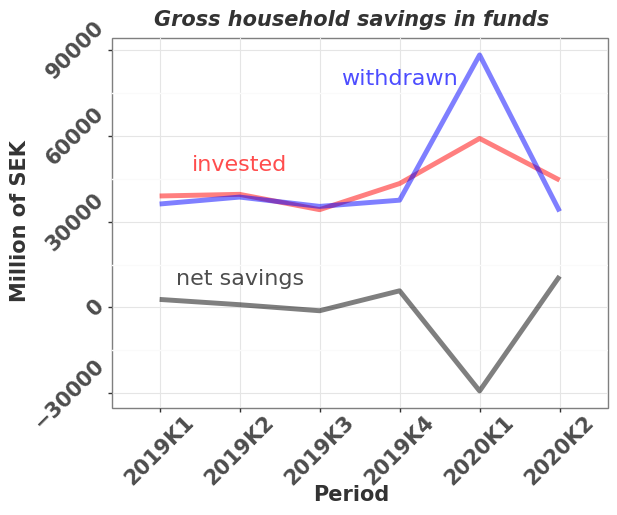

<ggplot: (8749017818765)> 

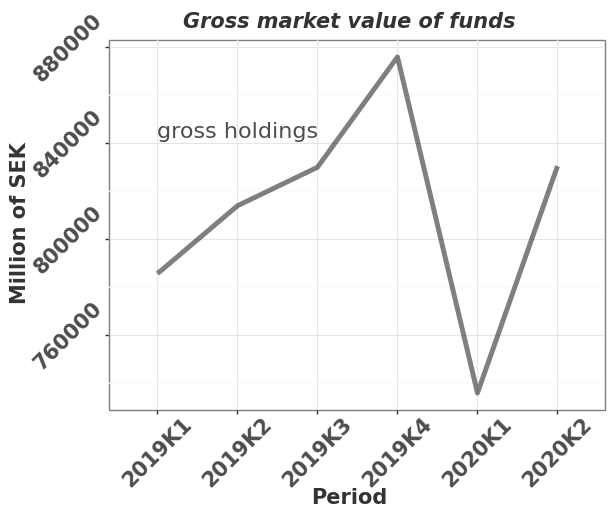

<ggplot: (-9223363287832825740)>


In [7]:

# do i need to 

img1=(ggplot(df, aes(x=df.index))+
    geom_line(mapping=aes(y='Gross savings in funds, sales'),
              group=1, colour="red", alpha = 0.5, size = 2)+
    annotate("text", x=df.index[1], y=50000, label="invested", size=16, colour="red", alpha=0.7)+
    #
    geom_line(mapping=aes(y='Gross savings in funds, redemptions'),
              group=2, colour="blue",  alpha=0.5, size = 2) +
    annotate("text", x=df.index[3], y = 80000, label="withdrawn", size=16, colour="blue", alpha=0.7)+
    #   
    geom_line(mapping=aes(y='Net savings in funds'),
              group=3,  alpha = 0.5, size = 2) +
    annotate("text", x=df.index[1], y=10000, label="net savings", size=16, alpha=0.7)+
    #   
    labs(title="Gross household savings in funds", x='Period', y='Million of SEK') # customizing labels
)

img2=(ggplot(df, aes(x=df.index))+
    geom_line(mapping=aes(y='Market value of funds'), group = 1,  alpha = 0.5, size = 2) +
    annotate("text", x=df.index[1], y=845000, label="gross holdings", size=16, alpha=0.7)+
    labs(title="Gross market value of funds", x='Period', y='Million of SEK') # customizing labels
)

print(img1,img2)
img1.save(filename='household_saving_in_funds.png', verbose=False)
img2.save(filename='household_holdings_in_funds.png', verbose=False)
